/var/folders/zb/1vtwn9rj08lghdmmhfhb0d280000gn/T/ipykernel_29666/2298430850.py:40: DeprecationWarning:

*choropleth_mapbox* is deprecated! Use *choropleth_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



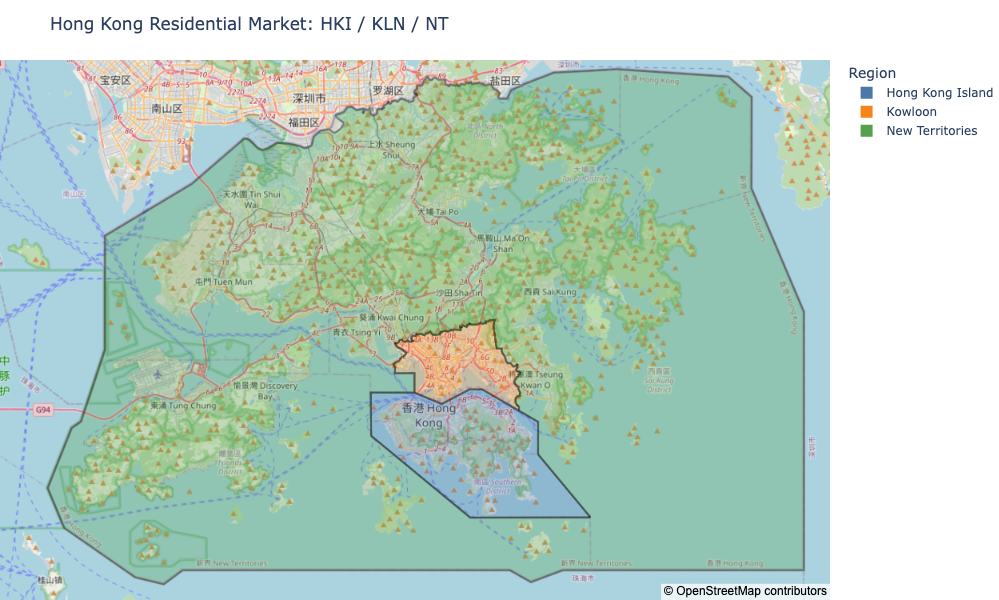

In [13]:
import requests
import geopandas as gpd
import plotly.express as px

# 1) Load HAD district boundaries
url = "https://www.had.gov.hk/psi/hong-kong-administrative-boundaries/hksar_18_district_boundary.json"
hk_geo = requests.get(url).json()

gdf = gpd.GeoDataFrame.from_features(hk_geo["features"])
gdf = gdf.rename(columns={"District": "district"})

# 2) Map districts -> 3 regions
hki = ["Central & Western", "Wan Chai", "Eastern", "Southern"]
kowloon = ["Yau Tsim Mong", "Sham Shui Po", "Kowloon City", "Wong Tai Sin", "Kwun Tong"]

def map_region(d):
    if d in hki:
        return "Hong Kong Island"
    elif d in kowloon:
        return "Kowloon"
    else:
        return "New Territories"

gdf["Region"] = gdf["district"].apply(map_region)

# 3) Dissolve into 3 shapes
region_gdf = gdf.dissolve(by="Region", as_index=False)

# 4) IMPORTANT: ensure coordinates are lat/lon (EPSG:4326)
# If your bounds look huge (e.g., x ~ 800000), it's likely HK1980 grid (EPSG:2326).
minx, miny, maxx, maxy = region_gdf.total_bounds
if maxx > 180:  # not lon/lat
    region_gdf = region_gdf.set_crs(2326, allow_override=True).to_crs(4326)
else:
    region_gdf = region_gdf.set_crs(4326, allow_override=True)

region_geojson = region_gdf.__geo_interface__

# 5) Plot on a REAL basemap (this makes it look like Hong Kong)
fig = px.choropleth_mapbox(
    region_gdf,
    geojson=region_geojson,
    locations="Region",
    featureidkey="properties.Region",
    color="Region",
    color_discrete_map={
        "Hong Kong Island": "#4c78a8",
        "Kowloon": "#f58518",
        "New Territories": "#54a24b",
    },
    height=600,
    center={"lat": 22.35, "lon": 114.15},
    zoom=9.6,
    opacity=0.3
)

fig.update_layout(
    mapbox_style="open-street-map",   # no token needed
    margin=dict(l=0, r=0, t=60, b=0),
    title="Hong Kong Residential Market: HKI / KLN / NT"
)

fig.update_traces(
    marker_line_width=2,
    marker_line_color="black",
    hovertemplate="<b>%{location}</b><extra></extra>"
)

fig.show()



In [5]:
import copy

fig_export = copy.deepcopy(fig)


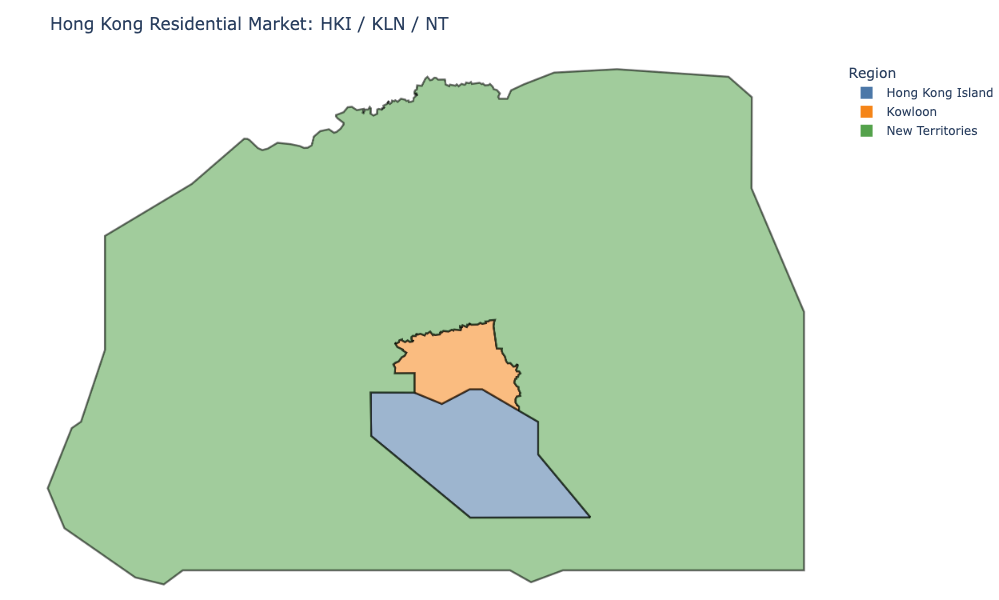

In [6]:
fig_export.update_layout(mapbox_style="white-bg")


In [7]:
fig_export.write_image(
    "hk_geographic_segmentation.png",
    width=2400,
    height=1400,
    scale=2
)


In [8]:
fig_export.write_image("hk_geographic_segmentation.svg")


In [9]:
import copy

fig_export = copy.deepcopy(fig)
fig_export.update_layout(mapbox_style="white-bg")

fig_export.write_image(
    "hk_geographic_segmentation.png",
    width=2400,
    height=1400,
    scale=2
)


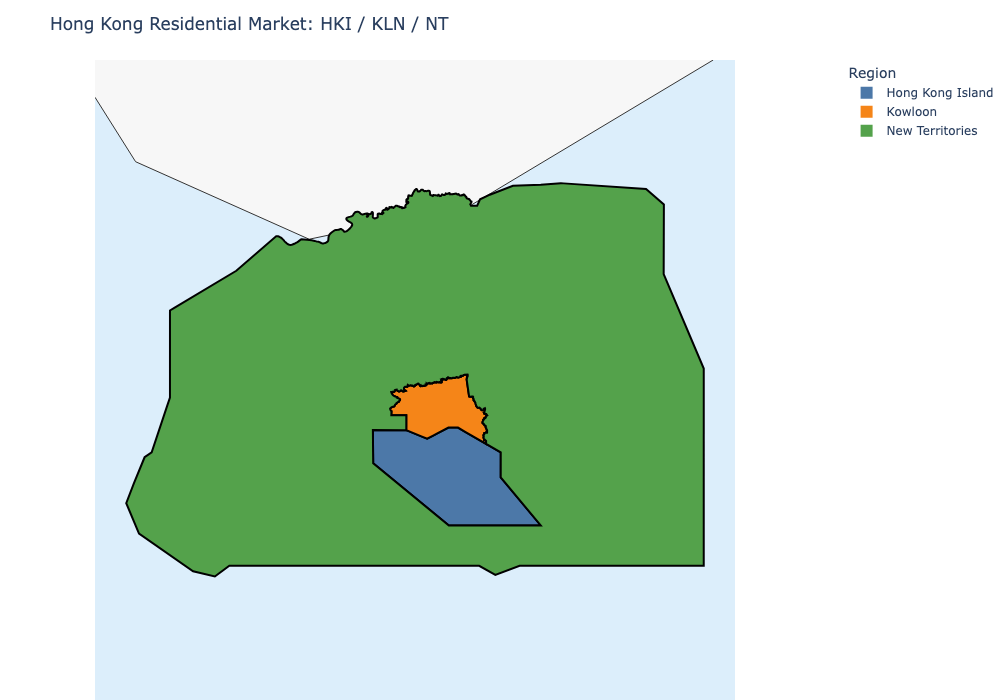

In [11]:
import requests
import geopandas as gpd
import plotly.express as px

# 1) Load HAD district boundaries
url = "https://www.had.gov.hk/psi/hong-kong-administrative-boundaries/hksar_18_district_boundary.json"
hk_geo = requests.get(url).json()

gdf = gpd.GeoDataFrame.from_features(hk_geo["features"]).rename(columns={"District": "district"})

# 2) Map districts -> 3 regions
hki = ["Central & Western", "Wan Chai", "Eastern", "Southern"]
kowloon = ["Yau Tsim Mong", "Sham Shui Po", "Kowloon City", "Wong Tai Sin", "Kwun Tong"]

def map_region(d):
    if d in hki:
        return "Hong Kong Island"
    elif d in kowloon:
        return "Kowloon"
    else:
        return "New Territories"

gdf["Region"] = gdf["district"].apply(map_region)

# 3) Dissolve into 3 shapes
region_gdf = gdf.dissolve(by="Region", as_index=False)

# 4) Ensure lon/lat CRS (EPSG:4326)
minx, miny, maxx, maxy = region_gdf.total_bounds
if maxx > 180 or maxy > 90:
    region_gdf = region_gdf.set_crs(2326, allow_override=True).to_crs(4326)
else:
    region_gdf = region_gdf.set_crs(4326, allow_override=True)

region_geojson = region_gdf.__geo_interface__

# 5) Use GEO (not mapbox) so export is reliable + still looks like a map
fig = px.choropleth(
    region_gdf,
    geojson=region_geojson,
    locations="Region",
    featureidkey="properties.Region",
    color="Region",
    color_discrete_map={
        "Hong Kong Island": "#4c78a8",
        "Kowloon": "#f58518",
        "New Territories": "#54a24b",
    },
)

# Make it look like a "real map" (coastline + ocean/land)
fig.update_geos(
    fitbounds="locations",
    projection=dict(type="mercator"),
    showocean=True, oceancolor="#dceefb",
    showland=True, landcolor="#f7f7f7",
    showcoastlines=True, coastlinecolor="#333",
    showsubunits=True, subunitcolor="#999",
    visible=False
)

fig.update_traces(
    marker_line_width=2,
    marker_line_color="black",
    hovertemplate="<b>%{location}</b><extra></extra>"
)

fig.update_layout(
    title="Hong Kong Residential Market: HKI / KLN / NT",
    margin=dict(l=0, r=0, t=60, b=0),
    width=1200,
    height=700
)

fig.show()

# 6) High-DPI export (no basemap tiles, so no Mapbox/Kaleido errors)
fig.write_image("hk_geographic_segmentation.png", width=2400, height=1400, scale=2)
# Optional vector export
fig.write_image("hk_geographic_segmentation.svg")
